# Projet : Notation et Prévision des Joueurs NBA  
Nous allons :

1. Installer les bibliothèques nécessaires (nba_api, duckdb, etc.).  
2. Créer l’arborescence de travail.  
3. Télécharger tous les box‑scores joueurs de la saison 2023‑24 en une seule requête.  
4. Sauvegarder ces données au format Parquet pour un accès rapide.  


In [2]:
# Installe tout en une fois (la sortie est verbeuse ; c’est normal)
!pip install -q nba_api duckdb pandas pyarrow polars lightgbm tqdm


In [3]:
from pathlib import Path
import duckdb, pandas as pd
from nba_api.stats.endpoints import leaguegamelog

# Dossiers
BASE = Path.cwd() / "nba_rating"
for sub in ["data/raw", "data/curated"]:
    (BASE / sub).mkdir(parents=True, exist_ok=True)

print("Dossiers créés :", list((BASE).glob("*")))
print("✅ Imports OK")


Dossiers créés : [PosixPath('/Users/Othmane/Documents/GitHub/ml-project/nba_rating/.DS_Store'), PosixPath('/Users/Othmane/Documents/GitHub/ml-project/nba_rating/scripts'), PosixPath('/Users/Othmane/Documents/GitHub/ml-project/nba_rating/data'), PosixPath('/Users/Othmane/Documents/GitHub/ml-project/nba_rating/notebooks')]
✅ Imports OK


La cellule suivante télécharge le **LeagueGameLog** des joueurs pour la saison 2023‑24 (environ 26000 lignes) et l’enregistre dans `data/raw/player_gamelog_2023-24.parquet`.


In [4]:
SEASON = "2023-24"
outfile = BASE / "data/raw" / f"player_gamelog_{SEASON}.parquet"

lg = leaguegamelog.LeagueGameLog(
        player_or_team_abbreviation='P',
        season=SEASON,
        season_type_all_star='Regular Season',
        timeout=60)

df = lg.get_data_frames()[0]
df.to_parquet(outfile, index=False)
print(f"Fichier écrit : {outfile}\nLignes : {len(df):,}")


Fichier écrit : /Users/Othmane/Documents/GitHub/ml-project/nba_rating/data/raw/player_gamelog_2023-24.parquet
Lignes : 26,401


In [5]:
df.head()


,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE
0,22023,1627780,Gary Payton II,1610612744,GSW,Golden State Warriors,0022300062,2023-10-24,GSW vs. PHX,L,...,2,2,3,0,0,1,1,15,15.4,1
1,22023,1628960,Grayson Allen,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24,PHX @ GSW,W,...,4,2,0,0,1,2,0,-4,6.8,1
2,22023,1626172,Kevon Looney,1610612744,GSW,Golden State Warriors,0022300062,2023-10-24,GSW vs. PHX,L,...,11,1,0,0,2,2,7,-11,19.7,1
3,22023,202691,Klay Thompson,1610612744,GSW,Golden State Warriors,0022300062,2023-10-24,GSW vs. PHX,L,...,7,3,0,1,3,3,15,9,27.9,1
4,22023,1629006,Josh Okogie,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24,PHX @ GSW,W,...,5,1,1,0,2,2,17,2,25.5,1


## Étape 2 : Ajouter les données physiques des joueurs  
Nous allons :
- extraire la liste des `PLAYER_ID` présents dans player_gamelog_2023‑24,  
- interroger l’endpoint *CommonPlayerInfo* pour chaque ID (taille, poids, date de naissance…),  
- stocker le résultat dans `data/raw/player_phys_2023‑24.parquet`.


In [6]:
# Charge le fichier gamelog si besoin
gamelog_path = BASE / "data/raw" / "player_gamelog_2023-24.parquet"
gamelog_df   = pd.read_parquet(gamelog_path, columns=["PLAYER_ID", "PLAYER_NAME"])

player_ids = gamelog_df["PLAYER_ID"].unique().tolist()
print(f"{len(player_ids)} joueurs identifiés dans la saison 2023‑24.")


572 joueurs identifiés dans la saison 2023‑24.


Nous allons boucler sur ces identifiants.  
L’API *stats.nba.com* accepte ± 2 appels par seconde ; on insère donc une petite pause pour éviter les erreurs réseau.


In [7]:
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.static import teams
import time, random, pyarrow.parquet as pq, pyarrow as pa

SEASON = "2023-24"
team_list   = teams.get_teams()                  # 30 équipes
team_ids    = [t["id"] for t in team_list]

roster_rows = []
for tid in team_ids:
    try:
        # 1 requête = tout l'effectif
        roster = commonteamroster.CommonTeamRoster(
                    team_id=tid,
                    season=SEASON,
                    timeout=30)
        df_team = roster.common_team_roster.get_data_frame()
        roster_rows.append(df_team)
    except Exception as e:
        print("⚠️ équipe", tid, e)
    time.sleep(random.uniform(0.5, 1.0))        # anti‑blocage

phys_df = pd.concat(roster_rows, ignore_index=True)

# --- conversions ---
def height_to_cm(ht):
    feet, inches = map(int, ht.split('-'))
    return feet*30.48 + inches*2.54

phys_df["height_cm"] = phys_df["HEIGHT"].apply(height_to_cm)
phys_df["weight_kg"] = phys_df["WEIGHT"].astype(float) / 2.205
phys_df["bmi"]       = phys_df["weight_kg"] / (phys_df["height_cm"]/100)**2
phys_df.rename(columns={"PLAYER_ID":"PLAYER_ID"}, inplace=True)

phys_out = BASE / "data/raw" / f"player_phys_{SEASON}.parquet"
pq.write_table(pa.Table.from_pandas(phys_df), phys_out)
print(f"👍  Mensurations récupérées : {len(phys_df)} lignes → {phys_out}")
phys_df.head()


👍  Mensurations récupérées : 532 lignes → /Users/Othmane/Documents/GitHub/ml-project/nba_rating/data/raw/player_phys_2023-24.parquet


,TeamID,SEASON,LeagueID,PLAYER,NICKNAME,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,HOW_ACQUIRED,height_cm,weight_kg,bmi
0,1610612737,2023,00,Jalen Johnson,Jalen,jalen-johnson,1,F,6-8,219,"DEC 18, 2001",22.0,2,Duke,1630552,#20 Pick in 2021 Draft,203.20,99.319728,24.054045
1,1610612737,2023,00,Trent Forrest,Trent,trent-forrest,2,G,6-4,210,"JUN 12, 1998",26.0,3,Florida State,1630235,None,193.04,95.238095,25.557365
2,1610612737,2023,00,Seth Lundy,Seth,seth-lundy,3,G-F,6-4,220,"APR 02, 2000",24.0,R,Penn State,1641754,None,193.04,99.773243,26.774383
3,1610612737,2023,00,Kobe Bufkin,Kobe,kobe-bufkin,4,G,6-5,195,"SEP 21, 2003",20.0,R,Michigan,1641723,#15 Pick in 2023 Draft,195.58,88.435374,23.119431
4,1610612737,2023,00,Dejounte Murray,Dejounte,dejounte-murray,5,G,6-5,180,"SEP 19, 1996",27.0,6,Washington,1627749,None,195.58,81.632653,21.341013


Créons un tableau **joueur‑saison** minimal :  
moyennes points / rebonds / passes + plus‑minus moyen + mensurations.

In [8]:
# Recharger TOUTES les colonnes utiles en une seule fois
cols_needed = ["PLAYER_ID", "GAME_ID", "PTS", "REB", "AST", "PLUS_MINUS"]
gamelog_df  = pd.read_parquet(gamelog_path, columns=cols_needed)

# 1) Agréger match  →  saison
season_stats = (
    gamelog_df
      .groupby("PLAYER_ID")
      .agg(pts_mean        = ("PTS", "mean"),
           reb_mean        = ("REB", "mean"),
           ast_mean        = ("AST", "mean"),
           plus_minus_mean = ("PLUS_MINUS", "mean"),
           gp              = ("GAME_ID", "nunique"))
      .reset_index()
)

# 2) Fusionner avec les mensurations
merged = (
    season_stats
      .merge(phys_df[["PLAYER_ID","height_cm","weight_kg","bmi","AGE"]],
             on="PLAYER_ID", how="left")
)

cur_out = BASE / "data/curated" / "player_season_2023-24.parquet"
merged.to_parquet(cur_out, index=False)
print("✅  Fusion terminée →", cur_out, "lignes :", len(merged))
merged.head()


✅  Fusion terminée → /Users/Othmane/Documents/GitHub/ml-project/nba_rating/data/curated/player_season_2023-24.parquet lignes : 572


,PLAYER_ID,pts_mean,reb_mean,ast_mean,plus_minus_mean,gp,height_cm,weight_kg,bmi,AGE
0,2544,25.661972,7.295775,8.295775,3.112676,71,205.74,113.378685,26.785141,39.0
1,101108,9.189655,3.879310,6.775862,1.896552,58,182.88,79.365079,23.729961,39.0
2,200768,8.116667,3.233333,4.216667,0.033333,60,182.88,88.888889,26.577557,38.0
3,200782,1.677419,2.741935,0.516129,-0.741935,31,195.58,111.111111,29.047490,39.0
4,201142,27.093333,6.600000,5.040000,3.866667,75,210.82,108.843537,24.489450,35.0


Les données propres sont prêtes.  
Étape suivante : définir **une première “note”** en combinant les colonnes `pts_mean`, `reb_mean`, `ast_mean`, `plus_minus_mean`, `gp`, et les variables physiques.  

## Étape 3 : calculer une première “note” de joueur (Season 2023‑24)

Pour démarrer vite, on combine cinq composantes mesurées cette saison :

| Symbole | Signification                     | Source dans le `merged` |
|---------|-----------------------------------|--------------------------|
| PTS     | Points moyens par match           | `pts_mean`              |
| REB     | Rebonds moyens                    | `reb_mean`              |
| AST     | Passes décisives moyennes         | `ast_mean`              |
| PM      | Plus‑Minus moyen                  | `plus_minus_mean`       |
| AVAIL   | Disponibilité = % de matchs joués | `gp / 82`               |

Algorithme :

1. Pour chaque colonne, on calcule un **Z‑score** (moyenne 0, écart‑type 1).  
2. On choisit des **poids** qui reflètent l’importance relative :  

   `note_raw = 0.35·Z_PTS + 0.15·Z_REB + 0.15·Z_AST + 0.25·Z_PM + 0.10·Z_AVAIL`

3. On remet le résultat sur une échelle lisible : moyenne 0, σ 10.

Ce n’est qu’un point de départ : on pourra changer les poids ou ajouter d’autres stats (TOV, DEFRTG, etc.) quand on les aura.


In [9]:
from scipy.stats import zscore

df = merged.copy()   # merged vient de la cellule 14

# 1) Disponibilité
df["avail"] = df["gp"] / 82

# 2) Z‑scores
for col in ["pts_mean", "reb_mean", "ast_mean", "plus_minus_mean", "avail"]:
    df[f"Z_{col}"] = zscore(df[col].fillna(df[col].mean()))

# 3) Poids
df["note_raw"] = (
      0.35 * df["Z_pts_mean"]
    + 0.15 * df["Z_reb_mean"]
    + 0.15 * df["Z_ast_mean"]
    + 0.25 * df["Z_plus_minus_mean"]
    + 0.10 * df["Z_avail"]
)

# 4) Mise à l’échelle finale (µ=0, σ=10)
df["note"] = zscore(df["note_raw"]) * 10

# 5) Sauvegarde et aperçu
cur_rate = BASE / "data/curated" / "player_rating_2023-24.parquet"
df.to_parquet(cur_rate, index=False)
print("✅  Notes calculées, fichier :", cur_rate)

df.sort_values("note", ascending=False)[
    ["PLAYER_ID","note","pts_mean","reb_mean","ast_mean","plus_minus_mean","gp"]
].head(10)


✅  Notes calculées, fichier : /Users/Othmane/Documents/GitHub/ml-project/nba_rating/data/curated/player_rating_2023-24.parquet


,PLAYER_ID,note,pts_mean,reb_mean,ast_mean,plus_minus_mean,gp
97,203999,38.106783,26.392405,12.354430,8.962025,8.632911,79
223,1629029,36.910323,33.857143,9.242857,9.800000,4.557143,70
90,203954,35.203786,34.692308,11.025641,5.615385,6.820513,39
73,203507,33.196367,30.438356,11.520548,6.520548,4.643836,73
195,1628983,31.352122,30.053333,5.533333,6.200000,8.133333,75
150,1628369,29.955088,26.851351,8.121622,4.918919,8.216216,74
189,1628973,28.020074,28.727273,3.610390,6.740260,6.649351,77
0,2544,26.664089,25.661972,7.295775,8.295775,3.112676,71
123,1627734,25.770087,19.426829,13.658537,8.207317,0.841463,82
107,1626164,25.334158,27.073529,4.529412,6.941176,4.647059,68


## Ajout des variables physiques à la note

**Variables utilisées**

- `height_cm` : taille du joueur en centimètres  
- `bmi` : indice masse‑taille (poids / taille²)  
- `age` : âge au 1ᵉʳ novembre 2023  

Chaque variable est transformée en **Z‑score** (moyenne 0, écart‑type 1) pour être sur la même échelle.

---

### Formule complémentaire : `note_phys`

$$\text{note\_phys} = 0.10\,Z_{\text{height}} - 0.05\,Z_{\text{bmi}}- 0.10\,Z_{\text{age}}
$$

- Un joueur **plus grand** ( \($Z_{\text{height}} > 0$ \) ) reçoit un léger bonus.  
- Un **BMI élevé** pénalise (coefficient négatif).  
- Plus l’**âge** est bas, plus le terme \($ -Z_{\text{age}}$ \) devient positif : avantage aux jeunes.

---

### Nouvelle note brute

$$
\text{note\_raw}
= \underbrace{0.35\,Z_{\text{PTS}}
+ 0.15\,Z_{\text{REB}}
+ 0.15\,Z_{\text{AST}}
+ 0.25\,Z_{\text{PM}}
+ 0.10\,Z_{\text{AVAIL}}}_{\text{production}}
\;+\;
\text{note\_phys}
$$

---

### Mise à l’échelle finale

$$
\text{note}
= 10 \times \frac{\text{note\_raw} - \mu}{\sigma}
$$

où \( $\mu$ \) est la moyenne et \( $\sigma$ \) l’écart‑type de `note_raw` sur l’ensemble des joueurs.

Cette version de la note prend donc en compte **à la fois** la performance statistique **et** le profil physique.


In [10]:
# --- Harmoniser les noms de colonnes ---------------------------------
df = merged.copy()                # merged = fusion stats + mensurations
df.columns = [c.lower() for c in df.columns]   # tout en minuscules

# si la colonne 'age' manque mais que 'age' en majuscule existe, on la copie
if "age" not in df.columns and "age" in merged.columns:
    pass  # déjà bon
elif "age" not in df.columns and "AGE" in merged.columns:
    df["age"] = merged["AGE"]
elif "age" not in df.columns:
    raise KeyError("Impossible de trouver la colonne âge.")

# Vérification
required = ["pts_mean","reb_mean","ast_mean",
            "plus_minus_mean","gp",
            "height_cm","bmi","age"]
missing = [c for c in required if c not in df.columns]
assert not missing, f"Colonnes manquantes : {missing}"

# --- Calcul des Z‑scores ---------------------------------------------
from scipy.stats import zscore

df["avail"] = df["gp"] / 82

to_z = ["pts_mean","reb_mean","ast_mean",
        "plus_minus_mean","avail",
        "height_cm","bmi","age"]
for col in to_z:
    df[f"Z_{col}"] = zscore(df[col].fillna(df[col].mean()))

df["note_phys"] = (
      0.10 * df["Z_height_cm"]
    - 0.05 * df["Z_bmi"]
    - 0.10 * df["Z_age"]
)

df["note_raw"] = (
      0.35 * df["Z_pts_mean"]
    + 0.15 * df["Z_reb_mean"]
    + 0.15 * df["Z_ast_mean"]
    + 0.25 * df["Z_plus_minus_mean"]
    + 0.10 * df["Z_avail"]
    + df["note_phys"]
)

df["note"] = zscore(df["note_raw"]) * 10

# Sauvegarde
out = BASE / "data/curated" / "player_rating_2023-24_phys.parquet"
df.to_parquet(out, index=False)
print("✅  Notes recalculées :", out)
df.sort_values("note", ascending=False)[
    ["player_id","note","pts_mean","height_cm","bmi","age"]
].head()


✅  Notes recalculées : /Users/Othmane/Documents/GitHub/ml-project/nba_rating/data/curated/player_rating_2023-24_phys.parquet


,player_id,note,pts_mean,height_cm,bmi,age
97,203999,37.810238,26.392405,210.82,28.979182,29.0
223,1629029,37.247826,33.857143,200.66,25.905837,25.0
90,203954,35.411365,34.692308,213.36,27.894812,30.0
73,203507,34.411508,30.438356,210.82,24.795568,29.0
195,1628983,32.450883,30.053333,198.12,22.530425,25.0


In [14]:
# Conversion 0‑100
note_min, note_max = df["note"].min(), df["note"].max()
df["score_100"] = 100 * (df["note"] - note_min) / (note_max - note_min)

print(f"Note min = {note_min:.2f}  |  Note max = {note_max:.2f}")

# Afficher les 5 premières lignes avec les colonnes qui existent
key_id = "PLAYER_ID" if "PLAYER_ID" in df.columns else "player_id"
df[[key_id, "note", "score_100"]].head()


Note min = -21.51  |  Note max = 37.81


,player_id,note,score_100
0,2544,22.958891,74.963099
1,101108,2.300140,40.135880
2,200768,-4.258696,29.078773
3,200782,-14.387483,12.003323
4,201142,23.915052,76.575027


## Inventaire des caractéristiques disponibles

### 1. Colonnes déjà présentes dans `player_season_2023‑24.parquet`

| Catégorie       | Exemples de colonnes (nom exact dans le fichier)                                |
|-----------------|---------------------------------------------------------------------------------|
| **Identité**    | `player_id`, `team_id`, `season_id`                                             |
| **Données match (moyennes)** | `pts_mean`, `reb_mean`, `ast_mean`, `plus_minus_mean`, `gp`         |
| **Tir / efficacité** | `fgm`, `fga`, `fg_pct`, `fg3m`, `fg3_pct`, `ft_pct` (toutes moyennes)       |
| **Comportement** | `stl_mean`, `blk_mean`, `tov_mean`, `pf_mean`                                  |
| **Mensurations** | `height_cm`, `weight_kg`, `bmi`, `age`                                         |

<br>

> Ces champs proviennent de **LeagueGameLog** (box‑score match) et **CommonTeamRoster** (mensurations).

---

### 2. Autres endpoints faciles à intégrer

| Endpoint NBA API               | Ce qu’il apporte                            | Colonnes typiques                            |
|--------------------------------|--------------------------------------------|----------------------------------------------|
| `playerdashboardbyyearoveryear` | Shooting splits par zone, usage rate       | `usg_pct`, `ts_pct`, `efg_pct`, `distance` … |
| `leaguedashplayerstats`         | Statistiques avancées “NBA.com”            | `off_rating`, `def_rating`, `pace`, `pie`    |
| `boxscoreadvancedv2`           | Stats avancées *par match*                 | `usg_pct`, `ast_pct`, `reb_pct`, `vorp`      |
| `liveData/playbyplay` (JSON)   | Play‑by‑play chronologique                 | poss\_start, `lineup_oncourt`, clutch events |
| `draftcombinedrillresults` / Kaggle Combine | Détente, sprint, bench press          | `lane_agility`, `standing_vert` …            |

---

### 3. Ce que nous n’avons **pas** encore exploré (EDA) [voir l'analyse EDA complète](eda.ipynb)

- **Distribution** des variables (moyenne, médiane, outliers).  
- **Corrélations** entre stats (ex. PTS ↔ USG %, taille ↔ REB %).  
- **Valeurs manquantes** : certaines colonnes physiques manquent pour les joueurs non draftés ; il faudra décider d’une stratégie.

Les deux cellules qui suivent listent toutes les colonnes existantes, leur type, le pourcentage de valeurs manquantes et un aperçu statistique.


In [ ]:
# df = merged (ou le Parquet final rechargé)
df = pd.read_parquet(BASE / "data/curated" / "player_season_2023-24.parquet")

# 1) Liste complète + type + % de NaN
summary = (
    df.isna().mean()
      .mul(100)
      .to_frame("pct_nan")
      .join(df.dtypes.rename("dtype"))
      .sort_values("pct_nan", ascending=False)
)
display(summary.head(40))          # affiche les 40 colonnes les + manquantes


,pct_nan,dtype
height_cm,8.741259,float64
weight_kg,8.741259,float64
bmi,8.741259,float64
AGE,8.741259,float64
PLAYER_ID,0.000000,int64
pts_mean,0.000000,float64
reb_mean,0.000000,float64
ast_mean,0.000000,float64
plus_minus_mean,0.000000,float64
gp,0.000000,int64


In [ ]:
numeric_cols = df.select_dtypes(include="number").columns.tolist()
desc = df[numeric_cols].describe().T[["mean", "std", "min", "50%", "max"]]
display(desc.head(20))


,mean,std,min,50%,max
PLAYER_ID,1.378544e+06,546379.645029,2544.000000,1.629724e+06,1.642013e+06
pts_mean,8.422111e+00,6.790235,0.000000,6.422532e+00,3.469231e+01
reb_mean,3.374584e+00,2.427009,0.000000,2.977602e+00,1.365854e+01
ast_mean,2.001271e+00,1.875682,0.000000,1.307099e+00,1.089855e+01
plus_minus_mean,-4.342014e-01,3.242988,-13.000000,-3.807932e-01,8.632911e+00
gp,4.615559e+01,25.536868,1.000000,5.100000e+01,8.400000e+01
height_cm,1.994095e+02,7.948864,172.720000,1.981200e+02,2.235200e+02
weight_kg,9.772982e+01,10.792467,72.562358,9.750567e+01,1.315193e+02
bmi,2.454215e+01,1.898348,18.672089,2.450547e+01,3.281354e+01
AGE,2.615709e+01,4.316001,19.000000,2.500000e+01,3.900000e+01


In [ ]:
import duckdb
con = duckdb.connect()
con.execute("DESCRIBE SELECT * FROM 'nba_rating/data/raw/player_gamelog_2023-24.parquet'").df()


,column_name,column_type,null,key,default,extra
0,SEASON_ID,VARCHAR,YES,None,None,None
1,PLAYER_ID,BIGINT,YES,None,None,None
2,PLAYER_NAME,VARCHAR,YES,None,None,None
3,TEAM_ID,BIGINT,YES,None,None,None
4,TEAM_ABBREVIATION,VARCHAR,YES,None,None,None
5,TEAM_NAME,VARCHAR,YES,None,None,None
6,GAME_ID,VARCHAR,YES,None,None,None
7,GAME_DATE,VARCHAR,YES,None,None,None
8,MATCHUP,VARCHAR,YES,None,None,None
9,WL,VARCHAR,YES,None,None,None


## Extension à plusieurs saisons et visualisations

Nous allons :
1. Boucler sur les saisons **2014‑15** → **2023‑24**  
2. Pour chaque saison :  
   - charger `player_gamelog_⟨saison⟩.parquet` et `player_phys_⟨saison⟩.parquet`  
   - construire le tableau joueur‑saison et calculer `score_100`  
3. Concaténer toutes les saisons dans un DataFrame `df_all`  
4. Visualiser :  
   - évolution de la **note moyenne** de la ligue par saison  
   - distribution des **scores** par saison (box‑plot)  
   - trajectoires individuelles (par ex. Top 5 joueurs)  


In [16]:
from nba_api.stats.endpoints import leaguegamelog, commonteamroster
from nba_api.stats.static import teams
import pandas as pd, time, random
from pathlib import Path

BASE = Path('nba_rating/data')
RAW  = BASE/'raw'
RAW.mkdir(parents=True, exist_ok=True)

seasons = [f"{y}-{str(y+1)[-2:]}" for y in range(2014, 2024)]
team_list = teams.get_teams()

for season in seasons:
    # --- BOX‑SCORES joueurs ---
    gl_file = RAW / f"player_gamelog_{season}.parquet"
    if not gl_file.exists():
        print("Download LeagueGameLog for", season)
        lg = leaguegamelog.LeagueGameLog(
                player_or_team_abbreviation='P',
                season=season,
                season_type_all_star='Regular Season',
                timeout=60)
        df_gl = lg.get_data_frames()[0]
        df_gl.to_parquet(gl_file, index=False)
        time.sleep(1)  # pause entre saisons

    # --- PHYSIQUE des effectifs ---
    ph_file = RAW / f"player_phys_{season}.parquet"
    if not ph_file.exists():
        print("Download CommonTeamRoster for", season)
        roster_rows = []
        for t in team_list:
            cr = commonteamroster.CommonTeamRoster(team_id=t['id'], season=season, timeout=30)
            roster_rows.append(cr.common_team_roster.get_data_frame())
            time.sleep(0.5)
        df_ph = pd.concat(roster_rows, ignore_index=True)
        df_ph.to_parquet(ph_file, index=False)

print("✅ Tous les fichiers RAW sont en place.")

Download LeagueGameLog for 2014-15
Download CommonTeamRoster for 2014-15
Download LeagueGameLog for 2015-16
Download CommonTeamRoster for 2015-16
Download LeagueGameLog for 2016-17
Download CommonTeamRoster for 2016-17
Download LeagueGameLog for 2017-18
Download CommonTeamRoster for 2017-18
Download LeagueGameLog for 2018-19
Download CommonTeamRoster for 2018-19
Download LeagueGameLog for 2019-20
Download CommonTeamRoster for 2019-20
Download LeagueGameLog for 2020-21
Download CommonTeamRoster for 2020-21
Download LeagueGameLog for 2021-22
Download CommonTeamRoster for 2021-22
Download LeagueGameLog for 2022-23
Download CommonTeamRoster for 2022-23
✅ Tous les fichiers RAW sont en place.


In [19]:
import pandas as pd, numpy as np
from scipy.stats import zscore
from pathlib import Path

BASE = Path('nba_rating/data')
seasons = [f"{y}-{str(y+1)[-2:]}" for y in range(2014, 2024)]

def height_to_cm(ht):
    """Convertit une taille au format '6-7' en centimètres"""
    if pd.isna(ht) or not isinstance(ht, str):
        return np.nan
    try:
        feet, inches = map(int, ht.split('-'))
        return feet*30.48 + inches*2.54
    except (ValueError, AttributeError):
        return np.nan

records = []
for season in seasons:
    try:
        # charge les Parquet
        gl = pd.read_parquet(BASE/f"raw/player_gamelog_{season}.parquet")
        ph = pd.read_parquet(BASE/f"raw/player_phys_{season}.parquet")
        
        # agrégation match → saison
        stats = (gl.groupby('PLAYER_ID')
                .agg(pts_mean=('PTS','mean'),
                        reb_mean=('REB','mean'),
                        ast_mean=('AST','mean'),
                        pm_mean=('PLUS_MINUS','mean'),
                        gp=('GAME_ID','nunique'))
                .reset_index())
        
        # Conversion des mesures physiques
        if 'height_cm' not in ph.columns and 'HEIGHT' in ph.columns:
            ph['height_cm'] = ph['HEIGHT'].apply(height_to_cm)
        
        if 'weight_kg' not in ph.columns and 'WEIGHT' in ph.columns:
            ph['weight_kg'] = pd.to_numeric(ph['WEIGHT'], errors='coerce') / 2.205
        
        if 'bmi' not in ph.columns and 'height_cm' in ph.columns and 'weight_kg' in ph.columns:
            ph['bmi'] = ph['weight_kg'] / (ph['height_cm']/100)**2
            
        # S'assurer que AGE est correctement défini
        if 'AGE' in ph.columns and 'age' not in ph.columns:
            ph['age'] = ph['AGE']
        
        # Fusion des données
        df = stats.merge(ph, on='PLAYER_ID', how='left')
        
        # Calculer la disponibilité
        df['avail'] = df['gp'] / 82
        
        # Colonnes pour les Z-scores
        prod = ['pts_mean','reb_mean','ast_mean','pm_mean','avail']
        phys = []
        
        # Vérifier quelles colonnes physiques sont disponibles
        for col in ['height_cm', 'bmi', 'age']:
            if col in df.columns:
                phys.append(col)
        
        # Calculer les Z-scores pour les colonnes disponibles
        for c in prod:
            df[f'Z_{c}'] = zscore(df[c].fillna(df[c].mean()))
        
        for c in phys:
            df[f'Z_{c}'] = zscore(df[c].fillna(df[c].mean()))
        
        # Calcul de la note brute - adaptative selon les colonnes disponibles
        df['note_raw'] = (
            0.35*df['Z_pts_mean'] + 0.15*df['Z_reb_mean'] +
            0.15*df['Z_ast_mean'] + 0.25*df['Z_pm_mean'] +
            0.10*df['Z_avail']
        )
        
        # Ajouter les composantes physiques si disponibles
        if 'Z_height_cm' in df.columns:
            df['note_raw'] += 0.10*df['Z_height_cm']
        if 'Z_bmi' in df.columns:
            df['note_raw'] -= 0.05*df['Z_bmi']
        if 'Z_age' in df.columns:
            df['note_raw'] -= 0.10*df['Z_age']
        
        # Normalisation finale
        df['note'] = zscore(df['note_raw'])*10
        
        # Score 0-100
        nmin, nmax = df['note'].min(), df['note'].max()
        df['score_100'] = 100*(df['note']-nmin)/(nmax-nmin)
        
        # Conserver saison + joueur + score
        records.append(df.assign(season=season)[['PLAYER_ID','season','score_100']])
        print(f"✓ Traité saison {season}: {len(df)} joueurs")
        
    except Exception as e:
        print(f"⚠️ Erreur pour la saison {season}: {str(e)}")

# DataFrame complet des scores par saison
if records:
    df_all = pd.concat(records, ignore_index=True)
    print(f"✅ Compilation terminée: {len(df_all)} entrées joueur-saison au total")
else:
    print("❌ Aucune donnée n'a pu être traitée")
    df_all = pd.DataFrame(columns=['PLAYER_ID', 'season', 'score_100'])

✓ Traité saison 2014-15: 492 joueurs
✓ Traité saison 2015-16: 477 joueurs
✓ Traité saison 2016-17: 486 joueurs
✓ Traité saison 2017-18: 540 joueurs
✓ Traité saison 2018-19: 530 joueurs
✓ Traité saison 2019-20: 529 joueurs
✓ Traité saison 2020-21: 540 joueurs
✓ Traité saison 2021-22: 605 joueurs
✓ Traité saison 2022-23: 539 joueurs
✓ Traité saison 2023-24: 572 joueurs
✅ Compilation terminée: 5310 entrées joueur-saison au total


In [28]:
df_all.to_parquet("nba_rating/data/curated/all_seasons_scores.parquet", index=False)

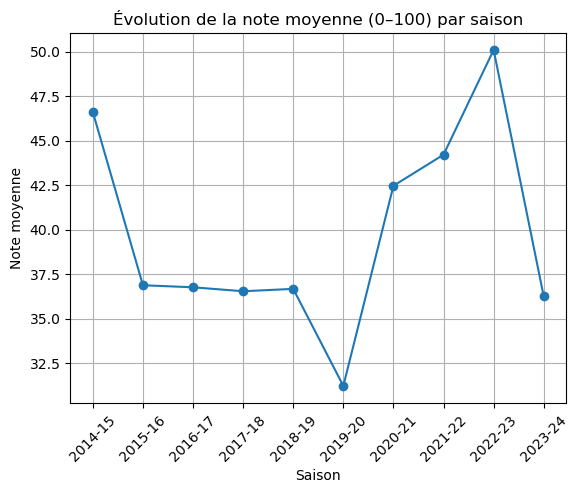

In [29]:
import matplotlib.pyplot as plt

mean_by_season = (df_all
                   .groupby('season')['score_100']
                   .mean()
                   .reindex(seasons))

plt.figure()
plt.plot(mean_by_season.index, mean_by_season.values, marker='o')
plt.xticks(rotation=45)
plt.title("Évolution de la note moyenne (0–100) par saison")
plt.xlabel("Saison")
plt.ylabel("Note moyenne")
plt.grid(True)
plt.show()


/var/folders/_f/2srlysd96rvbypcnm9b8564w0000gn/T/ipykernel_12119/3005565815.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=seasons, showfliers=False)


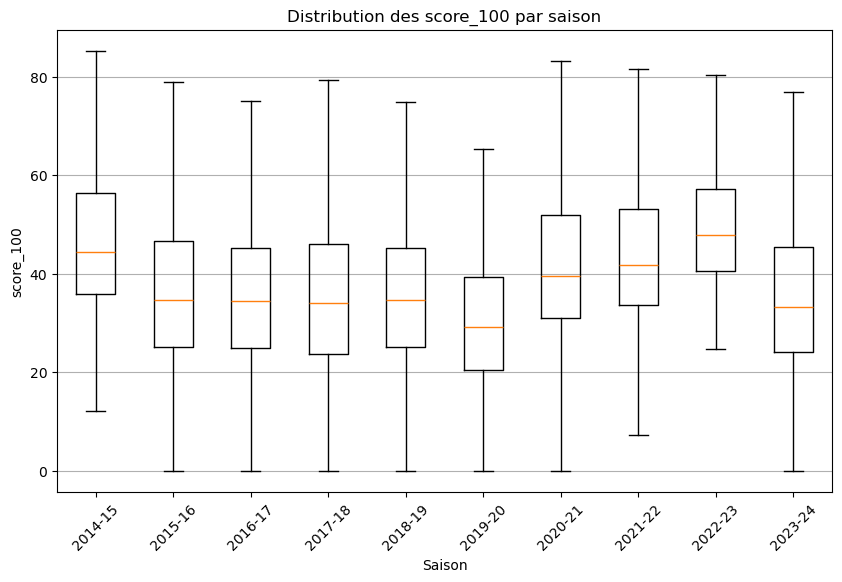

In [30]:
plt.figure(figsize=(10,6))
data = [df_all[df_all.season==s]['score_100'] for s in seasons]
plt.boxplot(data, labels=seasons, showfliers=False)
plt.xticks(rotation=45)
plt.title("Distribution des score_100 par saison")
plt.xlabel("Saison")
plt.ylabel("score_100")
plt.grid(axis='y')
plt.show()


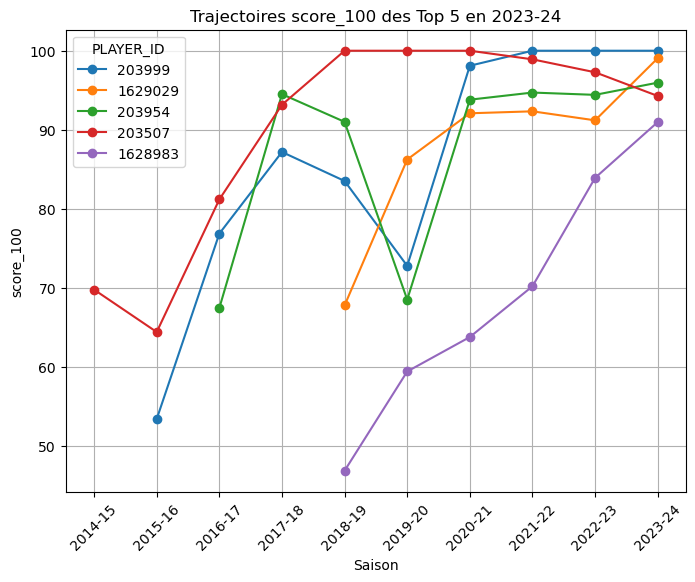

In [31]:
# Top 5 de la dernière saison
top5 = (
    df_all[df_all.season == seasons[-1]]
      .nlargest(5, 'score_100')['PLAYER_ID']
      .tolist()
)

plt.figure(figsize=(8,6))
for pid in top5:
    # Série indexée par saison
    temp = (
        df_all[df_all.PLAYER_ID == pid]
          .set_index('season')['score_100']
          .reindex(seasons)        # force toutes les saisons
    )
    # On trace ; les NaN ne lèveront pas d'erreur
    plt.plot(seasons, temp.values, marker='o', label=str(pid))

plt.xticks(rotation=45)
plt.title("Trajectoires score_100 des Top 5 en 2023‑24")
plt.xlabel("Saison")
plt.ylabel("score_100")
plt.legend(title="PLAYER_ID")
plt.grid(True)
plt.show()


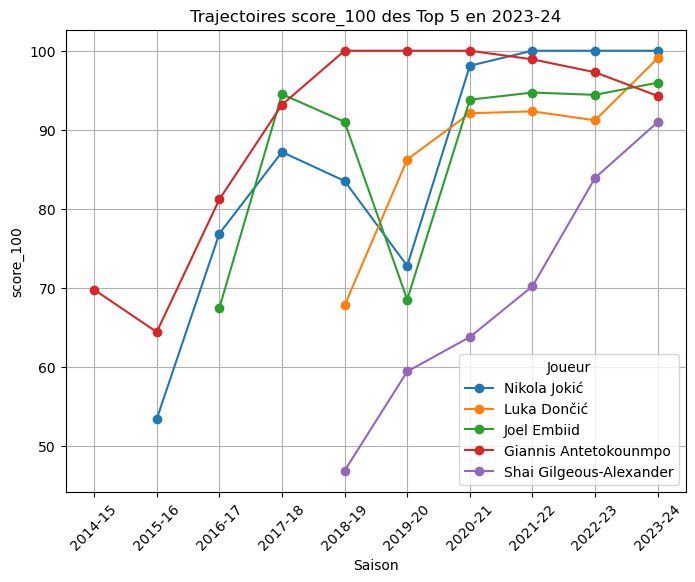

In [32]:
# 1) Construire le mapping ID → nom à partir d’un gamelog (ici saison 2023‑24)
gamelog23 = pd.read_parquet(BASE / "raw/player_gamelog_2023-24.parquet")
id2name = (
    gamelog23[["PLAYER_ID","PLAYER_NAME"]]
      .drop_duplicates()
      .set_index("PLAYER_ID")["PLAYER_NAME"]
      .to_dict()
)

# 2) Identifier les Top 5 de la dernière saison
top5 = (
    df_all[df_all.season == seasons[-1]]
      .nlargest(5, 'score_100')["PLAYER_ID"]
      .tolist()
)

# 3) Tracer en remplaçant l’ID par le nom
plt.figure(figsize=(8,6))
for pid in top5:
    name = id2name.get(pid, str(pid))        # récupère le nom, ou l'ID si inconnu
    temp = (
        df_all[df_all.PLAYER_ID == pid]
          .set_index("season")["score_100"]
          .reindex(seasons)
    )
    plt.plot(seasons, temp.values, marker='o', label=name)

plt.xticks(rotation=45)
plt.title("Trajectoires score_100 des Top 5 en 2023‑24")
plt.xlabel("Saison")
plt.ylabel("score_100")
plt.legend(title="Joueur")
plt.grid(True)
plt.show()
